# Key Considerations from Preprocessing and EDA:
* No missing values: Since there are no missing values, we don’t need to handle imputation.
* Categorical Variables: Some features such as C1, C2, and XC are categorical and should be encoded before feeding into the models. need to ensure that these are appropriately one-hot encoded.
* Standardization: The continuous variables such as X1, X2, etc., should be standardized. This helps models like linear models or neural networks.
* Imbalanced Treatment: We observed class imbalance between treated and control groups. Handling this imbalance will be crucial for fair treatment effect estimation.
* Interaction Effects: There may be interaction effects between treatment and school covariates (e.g., X1, X2) that could influence CATE, especially in models like X-learner and R-learner

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
import numpy as np
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt


In [46]:
# Load  data
dataset = pd.read_csv('../data/dataset.csv')

In [47]:
# Rename columns for clarity
dataset = dataset.rename(columns={
    'Y': 'StudentAchievementScore',
    'Z': 'GrowthMindsetIntervention',
    'S3': 'FutureSuccessExpectations',
    'C1': 'StudentRaceEthnicity',
    'C2': 'StudentGender',
    'C3': 'FirstGenCollegeStatus',
    'XC': 'SchoolUrbanicity',
    'X1': 'PreInterventionFixedMindset',
    'X2': 'SchoolAchievementLevel',
    'X3': 'SchoolMinorityComposition',
    'X4': 'PovertyConcentration',
    'X5': 'TotalStudentPopulation'
})

In [48]:
# Define covariates, treatment, and outcome
covariate_cols = ['FutureSuccessExpectations', 'StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 
                  'SchoolUrbanicity', 'PreInterventionFixedMindset', 'SchoolAchievementLevel', 
                  'SchoolMinorityComposition', 'PovertyConcentration', 'TotalStudentPopulation']
treatment_col = 'GrowthMindsetIntervention'
outcome_col = 'StudentAchievementScore'

In [49]:
# Split data into training and testing sets (with stratification on treatment variable)
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42, stratify=dataset[treatment_col])

In [50]:
# Preprocessing: Standardize continuous variables and one-hot encode categorical variables
continuous_cols = ['PreInterventionFixedMindset', 'SchoolAchievementLevel', 'SchoolMinorityComposition', 
                   'PovertyConcentration', 'TotalStudentPopulation']

categorical_cols = ['StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 'SchoolUrbanicity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

In [64]:
# Fit and transform the training data (covariates only)
X_train_processed = preprocessor.fit_transform(train_data[covariate_cols])

# Apply SMOTE to handle treatment imbalance (covariates and treatment together)
smote = SMOTE(random_state=42)
X_train_resampled, treatment_train_resampled = smote.fit_resample(X_train_processed, train_data[treatment_col])

# Now resample y_train using the same resampling process as X_train and treatment
y_train_resampled = smote.fit_resample(train_data[outcome_col].values.reshape(-1, 1), train_data[treatment_col])[0]

# Convert y_train_resampled to a 1D array (flatten it)
y_train_resampled = y_train_resampled.ravel()  # Ensure it's 1D

# Ensure that the resampled data have consistent sizes
assert X_train_resampled.shape[0] == y_train_resampled.shape[0] == treatment_train_resampled.shape[0], \
    f"Resampled shapes do not match: X={X_train_resampled.shape}, y={y_train_resampled.shape}, treatment={treatment_train_resampled.shape}"




In [65]:
# Define the parameter grid for each model
param_grids = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 100)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd']
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.1, 0.2, 0.5]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

In [71]:
def bootstrap_emse(X_train, y_train, treatment_train, model, n_bootstraps=100, meta_learner='S-Learner'):
    """
    Compute the Expected Mean Squared Error (EMSE) using bootstrapping for S-Learner, T-Learner, X-Learner, and R-Learner.
    
    Parameters:
    - X_train: Covariates
    - y_train: Outcome variable
    - treatment_train: Treatment assignment
    - model: The model to fit
    - n_bootstraps: Number of bootstrap samples
    - meta_learner: Type of meta-learner ('S-Learner', 'T-Learner', 'X-Learner', 'R-Learner')
    
    Returns:
    - emse: The Expected Mean Squared Error
    """
    mse_list = []
    
    for _ in range(n_bootstraps):
        # Bootstrap resampling
        X_boot, y_boot, t_boot = resample(X_train, y_train, treatment_train)
        
        if meta_learner == 'S-Learner':
            X_boot = np.column_stack([X_boot, t_boot])
            model.fit(X_boot, y_boot)
            cate_pred = model.predict(X_boot)
        
        elif meta_learner == 'T-Learner':
            # Separate models for treatment and control groups
            X_treat, y_treat = X_boot[t_boot == 1], y_boot[t_boot == 1]
            X_control, y_control = X_boot[t_boot == 0], y_boot[t_boot == 0]
            model_treat = model.__class__(**model.get_params())  # New instance of the model
            model_control = model.__class__(**model.get_params())  # New instance of the model
            model_treat.fit(X_treat, y_treat)
            model_control.fit(X_control, y_control)
            cate_pred = model_treat.predict(X_treat) - model_control.predict(X_control)

        elif meta_learner == 'X-Learner':
            # X-Learner first fits the T-Learner, then fits pseudo outcomes
            model_treat = model.__class__(**model.get_params())  # New instance of the model
            model_control = model.__class__(**model.get_params())  # New instance of the model
            X_treat, y_treat = X_boot[t_boot == 1], y_boot[t_boot == 1]
            X_control, y_control = X_boot[t_boot == 0], y_boot[t_boot == 0]
            
            model_treat.fit(X_treat, y_treat)
            model_control.fit(X_control, y_control)
            
            # Compute pseudo-outcomes
            tau_treat = y_treat - model_control.predict(X_treat)
            tau_control = model_treat.predict(X_control) - y_control
            
            # Refit the models using the pseudo-outcomes
            model_treat.fit(X_control, tau_control)
            model_control.fit(X_treat, tau_treat)
            cate_pred = np.concatenate([
                model_treat.predict(X_control),
                model_control.predict(X_treat)
            ])

        elif meta_learner == 'R-Learner':
            # Step 1: Residualize the outcome and treatment
            model_y = model.__class__(**model.get_params())  # New instance for outcome regression
            model_t = model.__class__(**model.get_params())  # New instance for treatment regression
            model_y.fit(X_boot, y_boot)
            model_t.fit(X_boot, t_boot)
            
            y_residual = y_boot - model_y.predict(X_boot)
            t_residual = t_boot - model_t.predict(X_boot)
            
            # Step 2: Regress the outcome residuals on treatment residuals
            model.fit(t_residual.reshape(-1, 1), y_residual)
            cate_pred = model.predict(t_residual.reshape(-1, 1))
        
        # Compute the MSE for this bootstrap sample
        mse_boot = mean_squared_error(y_boot, cate_pred)
        mse_list.append(mse_boot)
    
    # Compute the Expected MSE (EMSE)
    emse = np.mean(mse_list)
    return emse


In [72]:
from sklearn.metrics import mean_absolute_error

# Function for performing GridSearchCV
def grid_search_cv(X_train, y_train, treatment_train, model, params, meta_learner):
    """
    Perform GridSearchCV for hyperparameter tuning and return the best model along with EMSE and MAE.
    """

    # Ensure y_train is 1D
    y_train = y_train.ravel()
    
    # Combine covariates and treatment for S-Learner
    if meta_learner == 'S-Learner':
        X = np.column_stack([X_train, treatment_train])
    # For other learners, X stays the same
    elif meta_learner in ['T-Learner', 'X-Learner', 'R-Learner']:
        X = X_train
    
    # Run GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Compute EMSE using bootstrapping
    emse = bootstrap_emse(X_train, y_train, treatment_train, best_model, n_bootstraps=100, meta_learner=meta_learner)
    
    # Compute MAE on the predictions using the best model
    if meta_learner == 'S-Learner':
        X_best = np.column_stack([X_train, treatment_train])
    else:
        X_best = X_train
    
    y_pred = best_model.predict(X_best)
    best_mae = mean_absolute_error(y_train, y_pred)
    
    return best_model, emse, best_mae


In [73]:

# running grid search for each model and meta-learner
results = []
meta_learners = ['S-Learner', 'T-Learner', 'X-Learner', 'R-Learner']

for model_name, config in param_grids.items():
    for learner in meta_learners:
        print(f"Running GridSearchCV for {model_name} using {learner}...")
        
        # Run the grid search using the preprocessed and resampled data
        best_model, best_emse, best_mae = grid_search_cv(X_train_resampled, y_train_resampled, 
                                                         treatment_train_resampled, 
                                                         config['model'], config['params'], learner)
        
        # Store results
        result = {
            'model': model_name,
            'learner': learner,
            'best_emse': best_emse,
            'best_mae': best_mae
        }
        results.append(result)
        
        print(f"{learner} {model_name} Results: Best EMSE={best_emse:.4f}, Best MAE={best_mae:.4f}")

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)


Running GridSearchCV for RandomForest using S-Learner...


c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\dell\OneDrive\Desktop\The

S-Learner RandomForest Results: Best EMSE=0.2600, Best MAE=0.4376
Running GridSearchCV for RandomForest using T-Learner...


c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ValueError: operands could not be broadcast together with shapes (4920,) (4888,) 

In [40]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)
# Save the results as a CSV file
results_df.to_csv('grid_search_results.csv', index=False)
# Load the stored results from the CSV file
results_df = pd.read_csv('grid_search_results.csv')

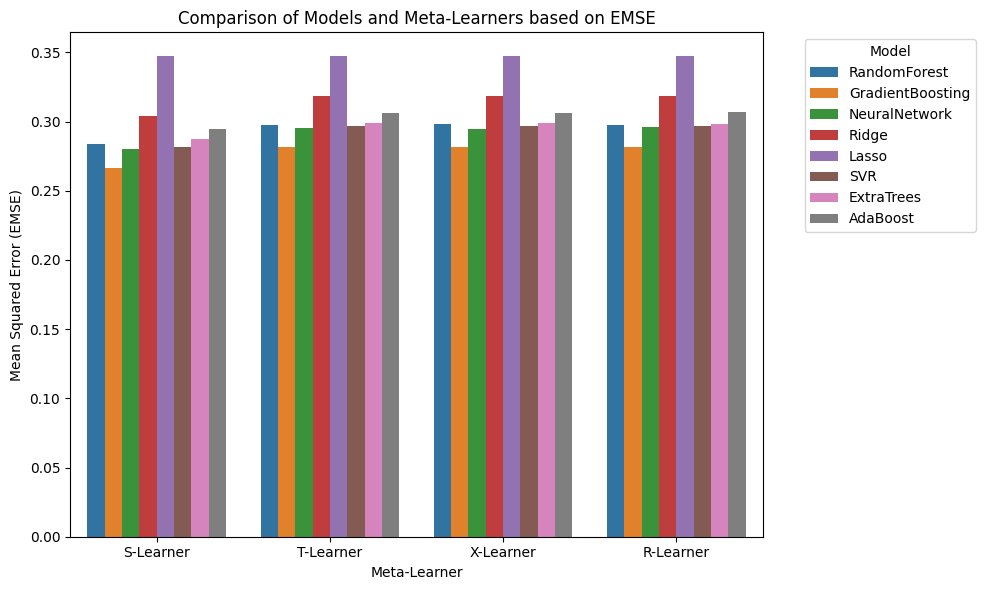

In [42]:
# 1. Bar Plot of MSE
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='learner', y='best_emse', hue='model', data=results_df)
plt.title('Comparison of Models and Meta-Learners based on EMSE')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Squared Error (EMSE)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


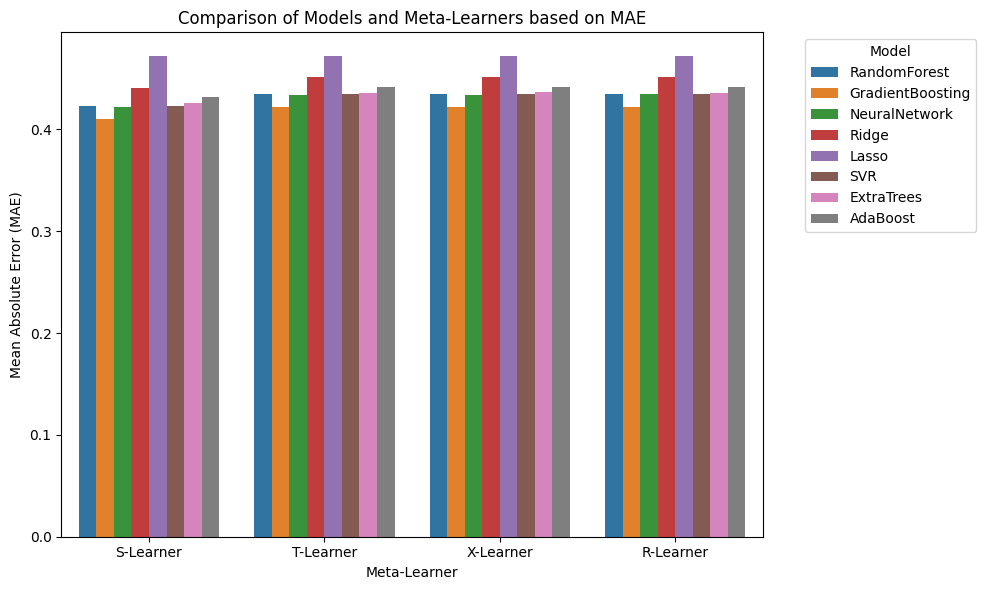

In [43]:
# 2. Bar Plot of MAE
plt.figure(figsize=(10, 6))
sns.barplot(x='learner', y='best_mae', hue='model', data=results_df)
plt.title('Comparison of Models and Meta-Learners based on MAE')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


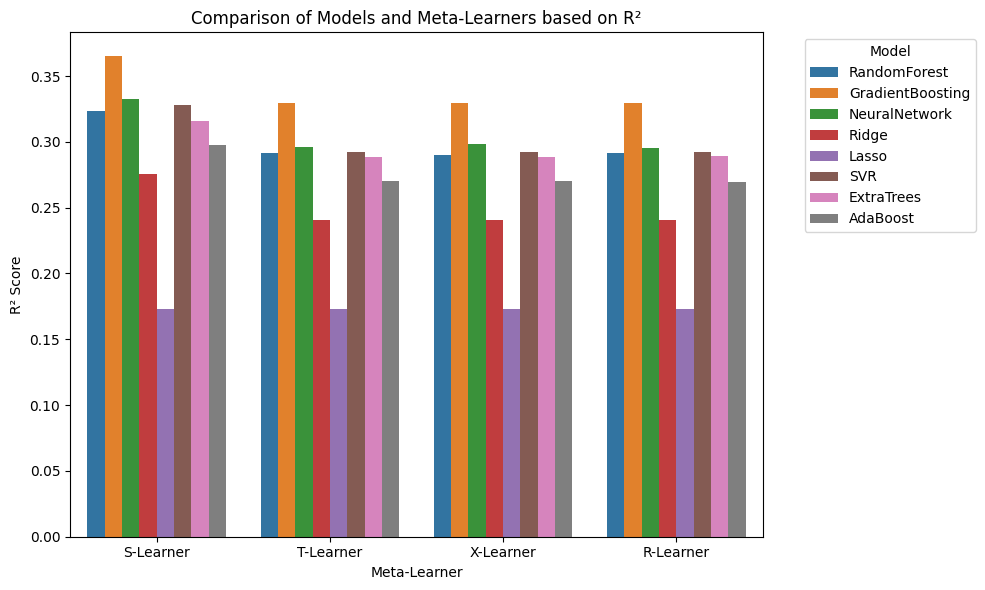

In [44]:
# 3. Bar Plot of R²
plt.figure(figsize=(10, 6))
sns.barplot(x='learner', y='best_r2', hue='model', data=results_df)
plt.title('Comparison of Models and Meta-Learners based on R²')
plt.xlabel('Meta-Learner')
plt.ylabel('R² Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Results 
## Key Metrics:
* Expected Mean Squared Error (EMSE): Lower values indicate better model performance, as the error between predicted and true treatment effects is minimized.
* Mean Absolute Error (MAE): Like EMSE, a lower value indicates better predictive accuracy.
* R² (R-squared): This measures the proportion of the variance in the outcome that is predictable from the covariates. Higher values (closer to 1) are better, indicating a better fit.
## Conclusions about Performance:
